<a href="https://colab.research.google.com/github/ryanhartman4/Computer-Vision-Side-Project/blob/main/Computer_Vision_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!wget --no-check-certificate \
    https://github.com/btphan95/simple-cnn/blob/master/train.zip?raw=true \
    -O /tmp/train.zip

--2020-10-24 20:35:50--  https://github.com/btphan95/simple-cnn/blob/master/train.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/btphan95/simple-cnn/raw/master/train.zip [following]
--2020-10-24 20:35:51--  https://github.com/btphan95/simple-cnn/raw/master/train.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/btphan95/simple-cnn/master/train.zip [following]
--2020-10-24 20:35:51--  https://raw.githubusercontent.com/btphan95/simple-cnn/master/train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118

In [46]:
!wget --no-check-certificate \
    https://github.com/btphan95/simple-cnn/blob/master/valid.zip?raw=true \
    -O /tmp/valid.zip

--2020-10-24 20:35:51--  https://github.com/btphan95/simple-cnn/blob/master/valid.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/btphan95/simple-cnn/raw/master/valid.zip [following]
--2020-10-24 20:35:52--  https://github.com/btphan95/simple-cnn/raw/master/valid.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/btphan95/simple-cnn/master/valid.zip [following]
--2020-10-24 20:35:52--  https://raw.githubusercontent.com/btphan95/simple-cnn/master/valid.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 192

In [47]:
#unzipping data
import os
import zipfile as zip

local_zip = '/tmp/train.zip'
zip_ref = zip.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
local_zip = '/tmp/valid.zip'
zip_ref = zip.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [48]:
#establish directories for two classes
train_dandelion_dir = os.path.join('/tmp/train/dandelion')
train_grass_dir = os.path.join('/tmp/train/grass')
valid_dandelion_dir = os.path.join('/tmp/valid/dandelion')
valid_grass_dir = os.path.join('/tmp/valid/grass')

In [49]:
#checking file names 
train_dandelion_names = os.listdir(train_dandelion_dir)

train_grass_names = os.listdir(train_grass_dir)

valid_grass_names = os.listdir(valid_grass_dir)

valid_dandelion_names = os.listdir(valid_dandelion_dir)


In [50]:
#checking file counts
print('Total # of dandelion images in train dataset:',len(os.listdir(train_dandelion_dir)))
print('Total # of grass images in train dataset:',len(os.listdir(train_grass_dir)))
print('Total # of valid dandelion images:',len(os.listdir(valid_dandelion_dir)))
print('Total # of valid grass images:',len(os.listdir(valid_grass_dir)))


Total # of dandelion images in train dataset: 500
Total # of grass images in train dataset: 499
Total # of valid dandelion images: 92
Total # of valid grass images: 65


In [51]:
#taking a look at some of the images provided
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#checking a 4x4 plot of 16 images
ncols = 4
nrows = 4
#iterating over images
pic_index = 0



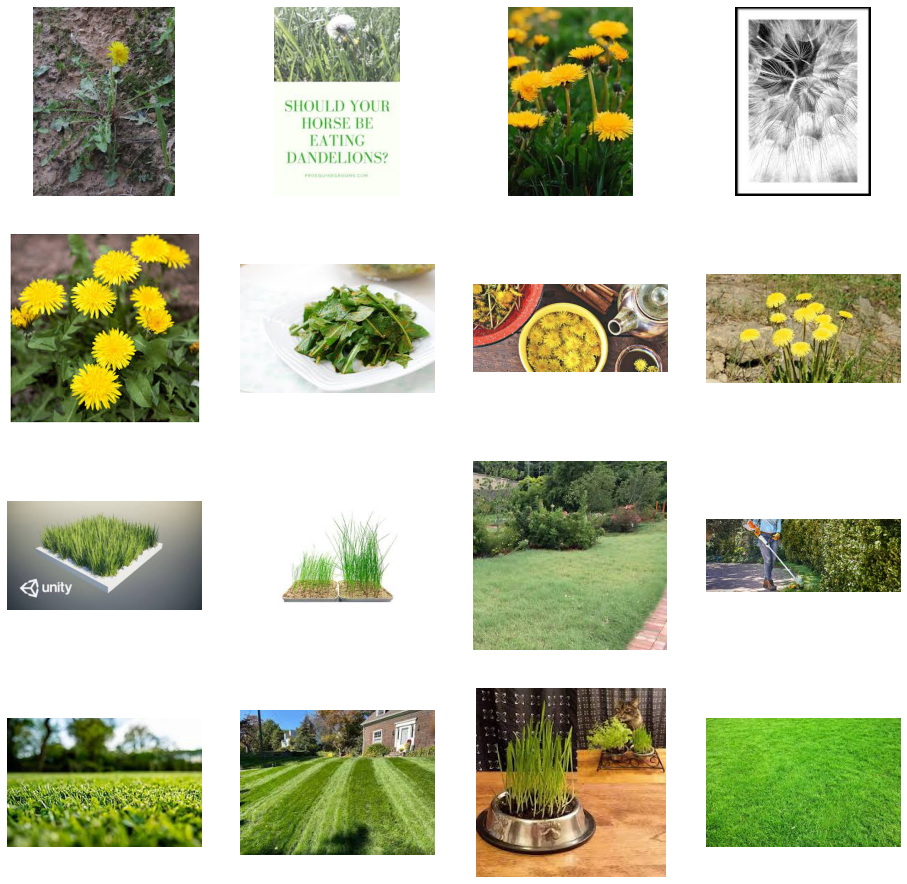

In [52]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows*4)

pic_index += 8

next_dand_pic = [os.path.join(train_dandelion_dir,fname)
              for fname in train_dandelion_names[pic_index-8:pic_index]]
next_grass_pic = [os.path.join(train_grass_dir,fname)
              for fname in train_grass_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_dand_pic + next_grass_pic):
  #setting subplot with image indices starting at one
  sp = plt.subplot(nrows, ncols, i +1)
  #turning off gridlines
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [64]:
#performing some preprocessing with keras 
#attempting to normalize data and place it into training and validation sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

#re-scale
train_datagen = IDG(rescale=1/255)
valid_datagen = IDG(rescale=1/255)

#batches of 120 flow for train
train_generator = train_datagen.flow_from_directory('/tmp/train/',
                                                    classes = ['dandelion','grass'],
                                                    target_size = (200,200),batch_size=120,
                                                    class_mode='binary')
#batches of 19 flow for valid
valid_generator = valid_datagen.flow_from_directory('/tmp/valid/', 
                                                    classes = ['dandelion','grass'],
                                                    target_size=(200,200),
                                                    batch_size = 19, 
                                                    class_mode = 'binary',
                                                    shuffle=False)




Found 999 images belonging to 2 classes.
Found 157 images belonging to 2 classes.


Going to try and build the model from scratch

In [54]:
#importing tools 
import tensorflow as tf
import numpy as np
from itertools import cycle

from scipy import interp

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, f1_score, auc, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


In [55]:
#building 2 layer seuential model with 128 hidden units and sigmoid final layer (since it's bianary classification). Going to flatten images first.
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape = (200,200,3)),
                             tf.keras.layers.Dense(128,activation = tf.nn.relu),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])


In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 120000)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               15360128  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 15,360,257
Trainable params: 15,360,257
Non-trainable params: 0
_________________________________________________________________


In [57]:
#compile model, using adam as optimiation alorithm because it will automate the learning tuning
model.compile(optimizer = tf.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [58]:
#Training model for 15 epochs using 960 of the available images
history = model.fit(train_generator, steps_per_epoch = 8, 
                    epochs = 15, 
                    verbose = 1, 
                    validation_data = valid_generator, 
                    validation_steps = 8)


Epoch 1/15
8/8 - 2s - loss: 17.0040 - accuracy: 0.4937
Epoch 2/15
8/8 - 2s - loss: 7.9902 - accuracy: 0.5358
Epoch 3/15
8/8 - 2s - loss: 3.1081 - accuracy: 0.6212
Epoch 4/15
8/8 - 2s - loss: 2.5885 - accuracy: 0.6098
Epoch 5/15
8/8 - 2s - loss: 1.6810 - accuracy: 0.6803
Epoch 6/15
8/8 - 3s - loss: 1.4291 - accuracy: 0.6974
Epoch 7/15
8/8 - 2s - loss: 1.2223 - accuracy: 0.7065
Epoch 8/15
8/8 - 2s - loss: 0.9652 - accuracy: 0.7486
Epoch 9/15
8/8 - 2s - loss: 0.9430 - accuracy: 0.7463
Epoch 10/15
8/8 - 2s - loss: 0.8035 - accuracy: 0.7304
Epoch 11/15
8/8 - 3s - loss: 1.2653 - accuracy: 0.6928
Epoch 12/15
8/8 - 2s - loss: 1.1703 - accuracy: 0.7270
Epoch 13/15
8/8 - 2s - loss: 0.9193 - accuracy: 0.7418
Epoch 14/15
8/8 - 2s - loss: 0.7733 - accuracy: 0.7486
Epoch 15/15
8/8 - 2s - loss: 0.6003 - accuracy: 0.8125


In [65]:
#evaluating model in terms of accuracy
model.evaluate(valid_generator)

9/9 [==============================] - 0s 37ms/step - loss: 1.2072 - accuracy: 0.6306


[1.2071517705917358, 0.6305732727050781]

In [67]:
#making predictions on validation set
stepsize_test = valid_generator.n//valid_generator.batch_size
valid_generator.reset()

first_predictions = model.predict(valid_generator,verbose = 0)


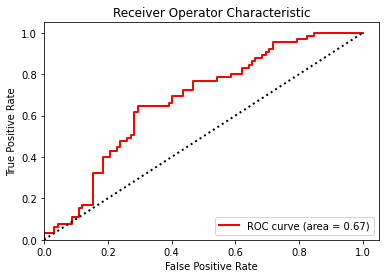

In [78]:
# creating roc curve

false_pos, true_pos, _ = roc_curve(valid_generator.classes, first_predictions)
roc_auc = auc(false_pos,true_pos)

plt.figure()
lw = 2
plt.plot(false_pos, true_pos, color = 'red', lw=lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], color = 'black', lw = lw, linestyle = ':')
plt.xlim([0.0,1.05])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.title('Receiver Operator Characteristic')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


Saving BMW Pic <1mb.jpg to BMW Pic <1mb.jpg
BMW Pic <1mb.jpgis grass


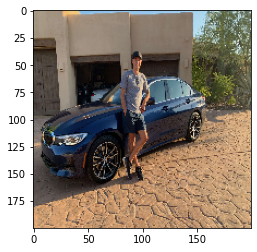

In [96]:
#trying it out on uploaded files!

from google.colab import files
import tensorflow.keras.preprocessing.image as image
uploaded = files.upload()

for fn in uploaded.keys():

  path = '/content/' + fn 
  img = image.load_img(path, target_size=(200,200))
  x = image.img_to_array(img)
  plt.imshow(x/255)
  x = np.expand_dims(x,axis=0)
  images= np.vstack([x])
  classes = model.predict(images, batch_size = 10)
  import numpy as numpy
  if classes[0]<.5:
    print(fn + 'is a dandelion')
  else :
    print(fn + ' is grass')